## Part II: Generative Adversarial Networks(GAN)
### Task1 
Build your GAN in PyTorch using the template my gan.py. Train it on the MNIST dataset provided in the dataset folder (the python file inside can be used to download the data and create the traninig and test sets).

In [9]:
import argparse
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets

from torch.autograd import Variable
import matplotlib.pyplot as plt
import pylab

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Construct generator. You should experiment with your model,
        # but the following is a good start:
        #   Linear args.latent_dim -> 128
        #   LeakyReLU(0.2)
        #   Linear 128 -> 256
        #   Bnorm
        #   LeakyReLU(0.2)
        #   Linear 256 -> 512
        #   Bnorm
        #   LeakyReLU(0.2)
        #   Linear 512 -> 1024
        #   Bnorm
        #   LeakyReLU(0.2)
        #   Linear 1024 -> 768
        #   Output non-linearity
        self.fc1 = nn.Linear(args.latent_dim, 128)
        self.lk_relu1 = nn.LeakyReLU(0.2)
        
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(num_features=256)
        self.lk_relu2 = nn.LeakyReLU(0.2)
        
        self.fc3 = nn.Linear(256, 512)
        self.bn3 = nn.BatchNorm1d(num_features=512)
        self.lk_relu3 = nn.LeakyReLU(0.2)
        
        self.fc4 = nn.Linear(512, 1024)
        self.bn4 = nn.BatchNorm1d(num_features=1024)
        self.lk_relu4 = nn.LeakyReLU(0.2)
        
        self.fc5 = nn.Linear(1024, 784)
        self.non_linear = nn.Tanh()
        

    def forward(self, z):
        # Generate images from z
        x = self.lk_relu1(self.fc1(z))
        x = self.lk_relu2( self.bn2(self.fc2(x)) )
        x = self.lk_relu3( self.bn3(self.fc3(x)) )
        x = self.lk_relu4( self.bn4(self.fc4(x)) )
        x = self.non_linear(self.fc5(x))
        return x


In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Construct distriminator. You should experiment with your model,
        # but the following is a good start:
        #   Linear 784 -> 512
        #   LeakyReLU(0.2)
        #   Linear 512 -> 256
        #   LeakyReLU(0.2)
        #   Linear 256 -> 1
        #   Output non-linearity
        self.fc1 = nn.Linear(784, 512)
        self.lk_relu1 = nn.LeakyReLU(0.2)
        
        self.fc2 = nn.Linear(512, 256)
        self.lk_relu2 = nn.LeakyReLU(0.2)
        
        self.fc3 = nn.Linear(256, 1)
        self.non_linear = nn.Sigmoid()
        
        
    def forward(self, img):
        # return discriminator score for img
        x = self.lk_relu1(self.fc1(img))
        x = self.lk_relu2(self.fc2(x))
        x = self.non_linear(self.fc3(x))
        return x


In [12]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [13]:
def reset_grad(optimizer_G, optimizer_D):
    optimizer_G.zero_grad()
    optimizer_D.zero_grad()

In [14]:
def train(dataloader, discriminator, generator, optimizer_G, optimizer_D):
    
    sample_dir = './images/samples'
    save_dir = './images/save'
    
    # Device setting
    discriminator = discriminator
    generator = generator
    
    # Binary cross entropy loss and optimizer
    criterion = nn.BCELoss()
    
    # Statistics to be saved
    d_losses = np.zeros(args.n_epochs)
    g_losses = np.zeros(args.n_epochs)
    real_scores = np.zeros(args.n_epochs)
    fake_scores = np.zeros(args.n_epochs)
    
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(args.batch_size, 1)
    real_labels = Variable(real_labels)
    fake_labels = torch.zeros(args.batch_size, 1)
    fake_labels = Variable(fake_labels)
    
    total_step = len(dataloader)
    
    # Generate samples for testing
    num_test_samples = 2
    test_noise = Variable(torch.randn(num_test_samples, args.latent_dim))
    
    
    for epoch in range(args.n_epochs):
        for i, (imgs, _) in enumerate(dataloader):

            # Train Discriminator
            if i+1 > 800:
                break
            imgs = imgs.view(args.batch_size, -1)
            imgs = Variable(imgs)
            outputs = discriminator(imgs)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs
            
            z = torch.randn(args.batch_size, args.latent_dim)
            z = Variable(z)
            fake_images = generator(z)
            outputs = discriminator(fake_images)
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs
            
            # Backprop and optimize
            d_loss = d_loss_real + d_loss_fake
            reset_grad(optimizer_G, optimizer_D)
            d_loss.backward()
            optimizer_D.step()
            # ---------------
            

            # Train Generator
            z = torch.randn(args.batch_size, args.latent_dim)
            z = Variable(z)
            fake_images = generator(z)
            outputs = discriminator(fake_images)
            
            # Backprop and optimize
            g_loss = criterion(outputs, real_labels)
            reset_grad(optimizer_G, optimizer_D)
            g_loss.backward()
            optimizer_G.step()
            # -------------------
            
            # =================================================================== #
            #                          Update Statistics                          #
            # =================================================================== #
            d_loss = d_loss.item()
            g_loss = g_loss.item()

            d_losses[epoch] = d_losses[epoch]*(i/(i+1.)) + d_loss*(1./(i+1.))
            g_losses[epoch] = g_losses[epoch]*(i/(i+1.)) + g_loss*(1./(i+1.))
            real_scores[epoch] = real_scores[epoch]*(i/(i+1.)) + real_score.mean().item()*(1./(i+1.))
            fake_scores[epoch] = fake_scores[epoch]*(i/(i+1.)) + fake_score.mean().item()*(1./(i+1.))

            if (i+1) % 200 == 0:
                print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                      .format(epoch, args.n_epochs, i+1, total_step, d_loss, g_loss, 
                              real_score.mean().item(), fake_score.mean().item()))
            
            
            # Save Images
            # -----------
            gen_imgs = fake_images
            gen_imgs = gen_imgs.view(gen_imgs.size(0), 1, 28, 28)
            
            batches_done = epoch * len(dataloader) + i
            if batches_done % args.save_interval == 0:
                # You can use the function save_image(Tensor (shape Bx1x28x28),
                # filename, number of rows, normalize) to save the generated
                # images, e.g.:
                save_image(denorm(gen_imgs[:25].data),
                           'images/{}.png'.format(batches_done),
                           nrow=5, normalize=True)
            if (batches_done+1) % 100 == 0:
               
                test_images = generator(test_noise)
                test_images = test_images.view(test_images.size(0), 1, 28, 28)
                save_image(denorm(test_images.data), 'images/test/{}.png'.format(batches_done))
        
        #######
        # Save real images
        if (epoch+1) == 1:
            imgs = imgs.view(imgs.size(0), 1, 28, 28)
            save_image(denorm(imgs.data), os.path.join(sample_dir, 'real_images.png'))

        # Save sampled images
        fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
        save_image(denorm(fake_images.data), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

        # Save and plot Statistics
        np.save(os.path.join(save_dir, 'd_losses.npy'), d_losses)
        np.save(os.path.join(save_dir, 'g_losses.npy'), g_losses)
        np.save(os.path.join(save_dir, 'fake_scores.npy'), fake_scores)
        np.save(os.path.join(save_dir, 'real_scores.npy'), real_scores)

        plt.figure()
        pylab.xlim(0, args.n_epochs + 1)
        plt.plot(range(1, args.n_epochs + 1), d_losses, label='d loss')
        plt.plot(range(1, args.n_epochs + 1), g_losses, label='g loss')    
        plt.legend()
        plt.savefig(os.path.join(save_dir, 'loss.pdf'))
        plt.close()

        plt.figure()
        pylab.xlim(0, args.n_epochs + 1)
        pylab.ylim(0, 1)
        plt.plot(range(1, args.n_epochs + 1), fake_scores, label='fake score')
        plt.plot(range(1, args.n_epochs + 1), real_scores, label='real score')    
        plt.legend()
        plt.savefig(os.path.join(save_dir, 'accuracy.pdf'))
        plt.close()
        
        # Save model at checkpoints
        if (epoch+1) % 50 == 0:
            torch.save(generator.state_dict(), os.path.join(save_dir, 'G--{}.ckpt'.format(epoch+1)))
            torch.save(discriminator.state_dict(), os.path.join(save_dir, 'D--{}.ckpt'.format(epoch+1)))
        #######
    
    # Save the model checkpoints 
    torch.save(generator.state_dict(), 'G.ckpt')
    torch.save(discriminator.state_dict(), 'D.ckpt')


In [15]:
def interpolation(generator):
    test_num = 500
    save_interval = 10
    for i in range(test_num):
        z = torch.randn(args.batch_size, args.latent_dim)
        z = Variable(z)
        fake_images = generator(z)
        
        if i % save_interval == 0:
                # You can use the function save_image(Tensor (shape Bx1x28x28),
                # filename, number of rows, normalize) to save the generated
                # images, e.g.:
                gen_imgs = fake_images
                gen_imgs = gen_imgs.view(gen_imgs.size(0), 1, 28, 28)
                save_image(denorm(gen_imgs[:1].data),
                           'images/interpolation/{}.png'.format(i) ) 
            
            

In [16]:
def main():
    # Create output image directory
    os.makedirs('images', exist_ok=True)

    # load data
    dataloader = torch.utils.data.DataLoader(
        datasets.MNIST('./data/mnist', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))])),
        batch_size=args.batch_size, shuffle=True)

        
    # Initialize models and optimizers
    generator = Generator()
    discriminator = Discriminator()
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=args.lr)
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=args.lr)

    # Start training
    train(dataloader, discriminator, generator, optimizer_G, optimizer_D)
    
    interpolation(generator)

    # You can save your generator here to re-use it to generate images for your
    # report, e.g.:
    # torch.save(generator.state_dict(), "mnist_generator.pt")


In [17]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--n_epochs', type=int, default=200,
                        help='number of epochs')
    parser.add_argument('--batch_size', type=int, default=64,
                        help='batch size')
    parser.add_argument('--lr', type=float, default=0.0002,
                        help='learning rate')
    parser.add_argument('--latent_dim', type=int, default=100,
                        help='dimensionality of the latent space')
    parser.add_argument('--save_interval', type=int, default=500,
                        help='save every SAVE_INTERVAL iterations')
    args = parser.parse_known_args()[0]

    main()

Epoch [0/200], Step [200/938], d_loss: 0.1124, g_loss: 4.9666, D(x): 0.99, D(G(z)): 0.08
Epoch [0/200], Step [400/938], d_loss: 0.1329, g_loss: 6.8090, D(x): 0.97, D(G(z)): 0.09
Epoch [0/200], Step [600/938], d_loss: 0.1966, g_loss: 4.8296, D(x): 0.96, D(G(z)): 0.09
Epoch [0/200], Step [800/938], d_loss: 0.1810, g_loss: 6.9075, D(x): 0.94, D(G(z)): 0.07
Epoch [1/200], Step [200/938], d_loss: 0.2974, g_loss: 5.3610, D(x): 0.93, D(G(z)): 0.17
Epoch [1/200], Step [400/938], d_loss: 0.1292, g_loss: 5.9578, D(x): 0.94, D(G(z)): 0.05
Epoch [1/200], Step [600/938], d_loss: 0.2283, g_loss: 7.1719, D(x): 0.88, D(G(z)): 0.05
Epoch [1/200], Step [800/938], d_loss: 0.4202, g_loss: 5.4147, D(x): 0.92, D(G(z)): 0.20
Epoch [2/200], Step [200/938], d_loss: 0.3882, g_loss: 8.0636, D(x): 0.85, D(G(z)): 0.02
Epoch [2/200], Step [400/938], d_loss: 0.1850, g_loss: 5.3962, D(x): 0.95, D(G(z)): 0.11
Epoch [2/200], Step [600/938], d_loss: 0.2207, g_loss: 4.6043, D(x): 0.94, D(G(z)): 0.12
Epoch [2/200], Step [

Epoch [23/200], Step [200/938], d_loss: 0.4708, g_loss: 1.7609, D(x): 0.90, D(G(z)): 0.23
Epoch [23/200], Step [400/938], d_loss: 0.5883, g_loss: 2.1030, D(x): 0.81, D(G(z)): 0.22
Epoch [23/200], Step [600/938], d_loss: 0.9731, g_loss: 2.5489, D(x): 0.82, D(G(z)): 0.31
Epoch [23/200], Step [800/938], d_loss: 0.4765, g_loss: 3.0214, D(x): 0.88, D(G(z)): 0.19
Epoch [24/200], Step [200/938], d_loss: 0.5813, g_loss: 2.4838, D(x): 0.82, D(G(z)): 0.19
Epoch [24/200], Step [400/938], d_loss: 0.5830, g_loss: 2.3765, D(x): 0.82, D(G(z)): 0.19
Epoch [24/200], Step [600/938], d_loss: 0.7135, g_loss: 2.8614, D(x): 0.89, D(G(z)): 0.31
Epoch [24/200], Step [800/938], d_loss: 0.7292, g_loss: 2.1437, D(x): 0.85, D(G(z)): 0.29
Epoch [25/200], Step [200/938], d_loss: 0.6694, g_loss: 2.3581, D(x): 0.83, D(G(z)): 0.24
Epoch [25/200], Step [400/938], d_loss: 0.6977, g_loss: 2.5512, D(x): 0.81, D(G(z)): 0.18
Epoch [25/200], Step [600/938], d_loss: 0.6936, g_loss: 2.2542, D(x): 0.80, D(G(z)): 0.20
Epoch [25/

Epoch [46/200], Step [200/938], d_loss: 0.8682, g_loss: 1.9491, D(x): 0.70, D(G(z)): 0.17
Epoch [46/200], Step [400/938], d_loss: 0.5641, g_loss: 2.1342, D(x): 0.81, D(G(z)): 0.17
Epoch [46/200], Step [600/938], d_loss: 0.6934, g_loss: 2.0529, D(x): 0.87, D(G(z)): 0.34
Epoch [46/200], Step [800/938], d_loss: 0.5045, g_loss: 3.1399, D(x): 0.81, D(G(z)): 0.16
Epoch [47/200], Step [200/938], d_loss: 0.5759, g_loss: 1.8685, D(x): 0.76, D(G(z)): 0.12
Epoch [47/200], Step [400/938], d_loss: 0.6870, g_loss: 2.1897, D(x): 0.76, D(G(z)): 0.18
Epoch [47/200], Step [600/938], d_loss: 0.7652, g_loss: 1.7026, D(x): 0.77, D(G(z)): 0.25
Epoch [47/200], Step [800/938], d_loss: 0.5784, g_loss: 2.4306, D(x): 0.78, D(G(z)): 0.17
Epoch [48/200], Step [200/938], d_loss: 0.9985, g_loss: 2.4760, D(x): 0.66, D(G(z)): 0.20
Epoch [48/200], Step [400/938], d_loss: 0.8066, g_loss: 1.6361, D(x): 0.77, D(G(z)): 0.29
Epoch [48/200], Step [600/938], d_loss: 0.6228, g_loss: 2.4175, D(x): 0.80, D(G(z)): 0.22
Epoch [48/

Epoch [69/200], Step [200/938], d_loss: 0.7977, g_loss: 1.7365, D(x): 0.69, D(G(z)): 0.22
Epoch [69/200], Step [400/938], d_loss: 0.9630, g_loss: 1.4379, D(x): 0.76, D(G(z)): 0.36
Epoch [69/200], Step [600/938], d_loss: 0.9466, g_loss: 1.8064, D(x): 0.75, D(G(z)): 0.36
Epoch [69/200], Step [800/938], d_loss: 0.7513, g_loss: 1.6168, D(x): 0.72, D(G(z)): 0.23
Epoch [70/200], Step [200/938], d_loss: 0.7375, g_loss: 1.7214, D(x): 0.75, D(G(z)): 0.26
Epoch [70/200], Step [400/938], d_loss: 0.9920, g_loss: 1.4056, D(x): 0.64, D(G(z)): 0.26
Epoch [70/200], Step [600/938], d_loss: 0.7974, g_loss: 1.8683, D(x): 0.71, D(G(z)): 0.25
Epoch [70/200], Step [800/938], d_loss: 0.8841, g_loss: 1.4215, D(x): 0.81, D(G(z)): 0.39
Epoch [71/200], Step [200/938], d_loss: 0.7011, g_loss: 1.1860, D(x): 0.81, D(G(z)): 0.29
Epoch [71/200], Step [400/938], d_loss: 0.8761, g_loss: 1.3292, D(x): 0.78, D(G(z)): 0.34
Epoch [71/200], Step [600/938], d_loss: 0.8645, g_loss: 2.0990, D(x): 0.60, D(G(z)): 0.15
Epoch [71/

Epoch [92/200], Step [200/938], d_loss: 0.9013, g_loss: 1.3393, D(x): 0.63, D(G(z)): 0.23
Epoch [92/200], Step [400/938], d_loss: 0.6587, g_loss: 1.8513, D(x): 0.80, D(G(z)): 0.29
Epoch [92/200], Step [600/938], d_loss: 0.9202, g_loss: 1.1273, D(x): 0.71, D(G(z)): 0.34
Epoch [92/200], Step [800/938], d_loss: 0.9638, g_loss: 1.6300, D(x): 0.62, D(G(z)): 0.25
Epoch [93/200], Step [200/938], d_loss: 0.9201, g_loss: 1.6433, D(x): 0.68, D(G(z)): 0.32
Epoch [93/200], Step [400/938], d_loss: 0.8881, g_loss: 1.7317, D(x): 0.63, D(G(z)): 0.23
Epoch [93/200], Step [600/938], d_loss: 0.8480, g_loss: 1.5861, D(x): 0.71, D(G(z)): 0.31
Epoch [93/200], Step [800/938], d_loss: 0.9318, g_loss: 1.6033, D(x): 0.71, D(G(z)): 0.33
Epoch [94/200], Step [200/938], d_loss: 1.0972, g_loss: 1.5044, D(x): 0.60, D(G(z)): 0.28
Epoch [94/200], Step [400/938], d_loss: 0.8627, g_loss: 1.6436, D(x): 0.69, D(G(z)): 0.28
Epoch [94/200], Step [600/938], d_loss: 0.9126, g_loss: 1.4318, D(x): 0.72, D(G(z)): 0.34
Epoch [94/

Epoch [114/200], Step [800/938], d_loss: 1.0819, g_loss: 1.3447, D(x): 0.65, D(G(z)): 0.36
Epoch [115/200], Step [200/938], d_loss: 1.0740, g_loss: 1.2328, D(x): 0.74, D(G(z)): 0.45
Epoch [115/200], Step [400/938], d_loss: 0.9357, g_loss: 1.0513, D(x): 0.71, D(G(z)): 0.35
Epoch [115/200], Step [600/938], d_loss: 0.9472, g_loss: 1.4909, D(x): 0.65, D(G(z)): 0.30
Epoch [115/200], Step [800/938], d_loss: 0.9079, g_loss: 1.1915, D(x): 0.75, D(G(z)): 0.39
Epoch [116/200], Step [200/938], d_loss: 0.9590, g_loss: 1.6059, D(x): 0.70, D(G(z)): 0.35
Epoch [116/200], Step [400/938], d_loss: 1.0442, g_loss: 1.5595, D(x): 0.66, D(G(z)): 0.35
Epoch [116/200], Step [600/938], d_loss: 1.0608, g_loss: 1.5949, D(x): 0.60, D(G(z)): 0.29
Epoch [116/200], Step [800/938], d_loss: 1.0855, g_loss: 1.3546, D(x): 0.61, D(G(z)): 0.32
Epoch [117/200], Step [200/938], d_loss: 0.9567, g_loss: 1.6598, D(x): 0.65, D(G(z)): 0.29
Epoch [117/200], Step [400/938], d_loss: 1.1182, g_loss: 1.5414, D(x): 0.57, D(G(z)): 0.26

Epoch [137/200], Step [600/938], d_loss: 1.0207, g_loss: 1.3209, D(x): 0.63, D(G(z)): 0.32
Epoch [137/200], Step [800/938], d_loss: 1.1786, g_loss: 1.2055, D(x): 0.64, D(G(z)): 0.41
Epoch [138/200], Step [200/938], d_loss: 1.1652, g_loss: 1.1990, D(x): 0.60, D(G(z)): 0.38
Epoch [138/200], Step [400/938], d_loss: 1.0544, g_loss: 1.2557, D(x): 0.60, D(G(z)): 0.31
Epoch [138/200], Step [600/938], d_loss: 1.1044, g_loss: 1.1169, D(x): 0.69, D(G(z)): 0.42
Epoch [138/200], Step [800/938], d_loss: 0.9532, g_loss: 1.3496, D(x): 0.71, D(G(z)): 0.37
Epoch [139/200], Step [200/938], d_loss: 0.9738, g_loss: 1.3350, D(x): 0.64, D(G(z)): 0.29
Epoch [139/200], Step [400/938], d_loss: 1.1858, g_loss: 1.4972, D(x): 0.54, D(G(z)): 0.29
Epoch [139/200], Step [600/938], d_loss: 0.9515, g_loss: 1.1467, D(x): 0.67, D(G(z)): 0.34
Epoch [139/200], Step [800/938], d_loss: 0.8510, g_loss: 1.2145, D(x): 0.72, D(G(z)): 0.34
Epoch [140/200], Step [200/938], d_loss: 1.2109, g_loss: 1.2926, D(x): 0.68, D(G(z)): 0.47

Epoch [160/200], Step [400/938], d_loss: 0.9906, g_loss: 1.1024, D(x): 0.69, D(G(z)): 0.38
Epoch [160/200], Step [600/938], d_loss: 1.0520, g_loss: 0.9926, D(x): 0.62, D(G(z)): 0.33
Epoch [160/200], Step [800/938], d_loss: 1.0688, g_loss: 1.1706, D(x): 0.67, D(G(z)): 0.42
Epoch [161/200], Step [200/938], d_loss: 1.0352, g_loss: 1.0238, D(x): 0.73, D(G(z)): 0.43
Epoch [161/200], Step [400/938], d_loss: 1.0880, g_loss: 0.9538, D(x): 0.64, D(G(z)): 0.39
Epoch [161/200], Step [600/938], d_loss: 1.1406, g_loss: 1.1376, D(x): 0.62, D(G(z)): 0.37
Epoch [161/200], Step [800/938], d_loss: 1.1308, g_loss: 1.3132, D(x): 0.75, D(G(z)): 0.47
Epoch [162/200], Step [200/938], d_loss: 1.1353, g_loss: 0.9251, D(x): 0.63, D(G(z)): 0.41
Epoch [162/200], Step [400/938], d_loss: 1.1229, g_loss: 1.0741, D(x): 0.58, D(G(z)): 0.33
Epoch [162/200], Step [600/938], d_loss: 1.2627, g_loss: 1.2358, D(x): 0.70, D(G(z)): 0.48
Epoch [162/200], Step [800/938], d_loss: 1.1426, g_loss: 1.4623, D(x): 0.62, D(G(z)): 0.36

Epoch [183/200], Step [200/938], d_loss: 1.0243, g_loss: 1.2164, D(x): 0.63, D(G(z)): 0.33
Epoch [183/200], Step [400/938], d_loss: 1.0600, g_loss: 1.1236, D(x): 0.68, D(G(z)): 0.40
Epoch [183/200], Step [600/938], d_loss: 1.0822, g_loss: 1.2435, D(x): 0.64, D(G(z)): 0.38
Epoch [183/200], Step [800/938], d_loss: 0.9827, g_loss: 1.4728, D(x): 0.68, D(G(z)): 0.35
Epoch [184/200], Step [200/938], d_loss: 1.1401, g_loss: 1.3258, D(x): 0.59, D(G(z)): 0.33
Epoch [184/200], Step [400/938], d_loss: 0.9990, g_loss: 1.3153, D(x): 0.66, D(G(z)): 0.35
Epoch [184/200], Step [600/938], d_loss: 0.9614, g_loss: 1.2096, D(x): 0.62, D(G(z)): 0.30
Epoch [184/200], Step [800/938], d_loss: 1.1996, g_loss: 1.3623, D(x): 0.64, D(G(z)): 0.42
Epoch [185/200], Step [200/938], d_loss: 1.1729, g_loss: 1.2300, D(x): 0.56, D(G(z)): 0.33
Epoch [185/200], Step [400/938], d_loss: 1.0337, g_loss: 1.5157, D(x): 0.64, D(G(z)): 0.31
Epoch [185/200], Step [600/938], d_loss: 1.2023, g_loss: 1.1443, D(x): 0.57, D(G(z)): 0.35

#### Analyse training result:

During the training process, I save the `fake_score` and `real_score` to show the accuracy trend of both generator and discriminator, in the path `./images/save/accuracy.pdf`. As we can see from the picture below, the **fake score** of generator increases w.r.t. training epochs and finally reaches convergence. And the **real score** of discriminator decreases w.r.t. training epochs and also reaches convergence.

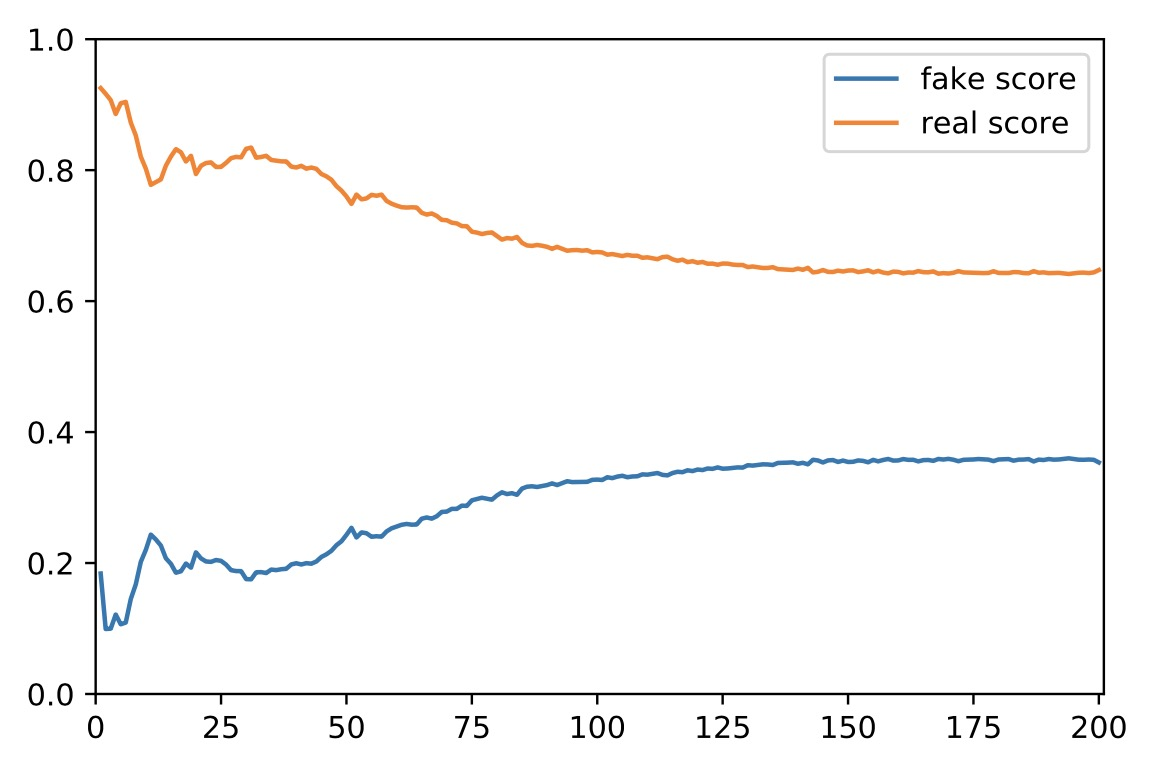

In [20]:
from IPython.display import Image

Image(filename = "accuracy.jpg", width=400, height=400)


And the following picture is the loss trend of both generator and discriminator:

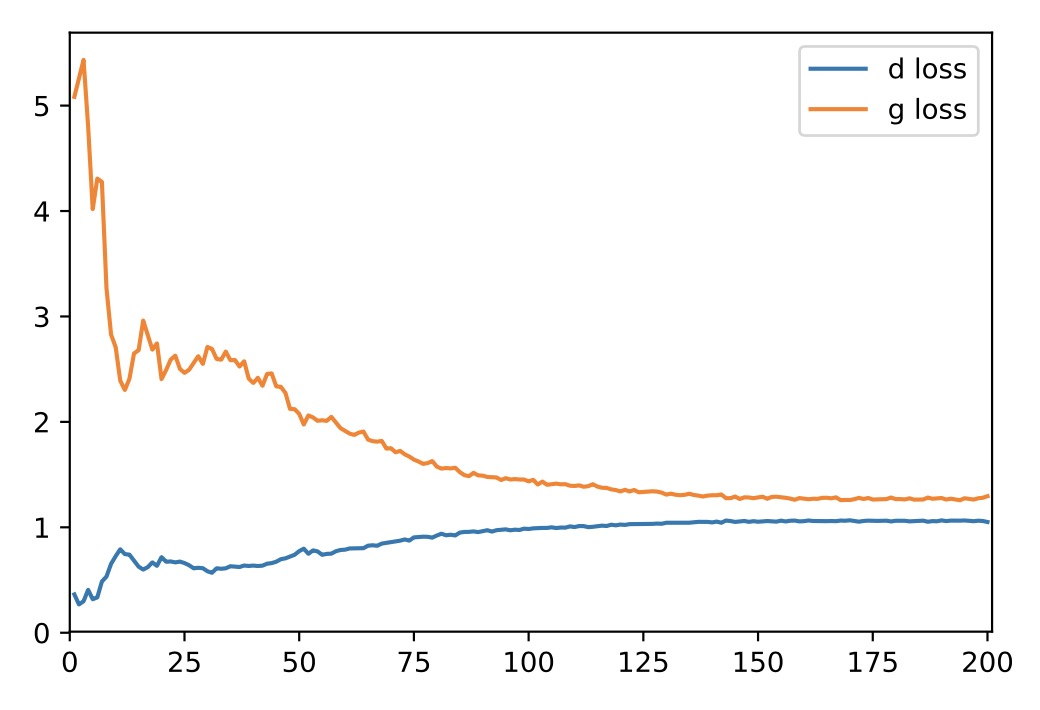

In [21]:
Image(filename = "loss.jpg", width=400, height=400)

### Task2
Sample 25 images from your trained GAN and include these in a jupyter notebook. Do this at the start of training, halfway through training and after training has terminated.

**During the training process, I sampled 25 images from my trained GAN every 500 batches.**

**The following are 25 sampled images after 0 batches, 500 batches, 1000 batches.** 

These images represent ***<u>the start of the training</u>***:

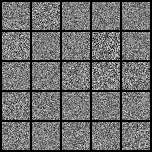

In [25]:
Image(filename = "./images/0.png")

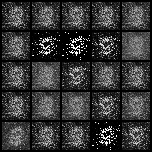

In [26]:
Image(filename = "./images/500.png")

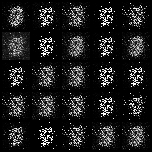

In [27]:
Image(filename = "./images/1000.png")

**The following are 25 sampled images after 93500(187000/2) batches.** 

This image represents ***<u>the halfway of the training</u>***:

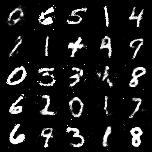

In [30]:
Image(filename = "./images/93500.png")

**The following are 25 sampled images after 187000 batches.** 

These images represent ***<u>the end of the training</u>***:

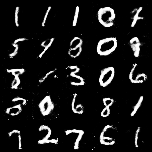

In [34]:
Image(filename = "./images/187000.png")

**To make it more clear, I also want to show 64 sampled images from the begining, halfway and endding of the training process:**

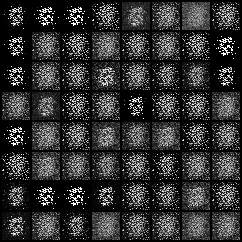

In [35]:
Image(filename = "./images/samples/fake_images-1.png")

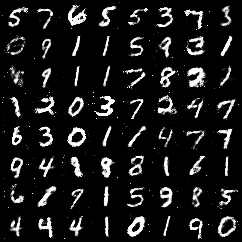

In [36]:
Image(filename = "./images/samples/fake_images-100.png")

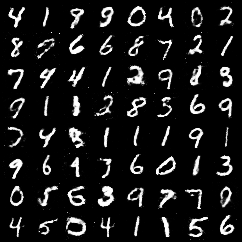

In [37]:
Image(filename = "./images/samples/fake_images-200.png")

### Task3
Sample 2 images from your GAN (make sure that they are of different classes). Interpolate between these two digits in latent space and include the results in your jupyter notebook. Use 7 interpolation steps, resulting in 9 images (including start and end point).


In [38]:
model = Generator()
PATH = './images/save/G--200.ckpt'
model_dict=model.load_state_dict(torch.load(PATH))

z1 = torch.randn(10, 100)
z1 = Variable(z1)
fake_images1 = model(z1)

fake_images1 = fake_images1.view(fake_images1.size(0), 1, 28, 28)
save_image(denorm(fake_images1.data),
                           '{}.png'.format('./task3_interpolate/fake_images1'))

In [39]:
z2 = torch.randn(10, 100)
z2 = Variable(z2)
fake_images2 = model(z2)

fake_images2 = fake_images2.view(fake_images2.size(0), 1, 28, 28)
save_image(denorm(fake_images2.data),
                           '{}.png'.format('./task3_interpolate/fake_images2'))

In [42]:
interpolate1 = 0.9 * fake_images1 + 0.1 * fake_images2
save_image(denorm(interpolate1.data),
                           '{}.png'.format('./task3_interpolate/interpolate1'))

interpolate2 = 0.75 * fake_images1 + 0.25 * fake_images2
save_image(denorm(interpolate2.data),
                           '{}.png'.format('./task3_interpolate/interpolate2'))

interpolate3 = 0.6 * fake_images1 + 0.4 * fake_images2
save_image(denorm(interpolate3.data),
                           '{}.png'.format('./task3_interpolate/interpolate3'))

interpolate4 = 0.5 * fake_images1 + 0.5 * fake_images2
save_image(denorm(interpolate4.data),
                           '{}.png'.format('./task3_interpolate/interpolate4'))

interpolate5 = 0.4 * fake_images1 + 0.6 * fake_images2
save_image(denorm(interpolate5.data),
                           '{}.png'.format('./task3_interpolate/interpolate5'))

interpolate6 = 0.25 * fake_images1 + 0.75 * fake_images2
save_image(denorm(interpolate6.data),
                           '{}.png'.format('./task3_interpolate/interpolate6'))


interpolate7 = 0.1 * fake_images1 + 0.9 * fake_images2
save_image(denorm(interpolate7.data),
                           '{}.png'.format('./task3_interpolate/interpolate7'))

**From this interpolation, I choose two images to show the process of interpolation: 6 and 7.**

In [45]:
save_image(denorm(fake_images1[6].data),
                           '{}.png'.format('./task3_interpolate/fake_images1_6'))
save_image(denorm(fake_images2[6].data),
                           '{}.png'.format('./task3_interpolate/fake_images2_6'))

In [50]:
save_image(denorm(interpolate1[6].data),
                           '{}.png'.format('./task3_interpolate/interpolate1_6'))
save_image(denorm(interpolate2[6].data),
                           '{}.png'.format('./task3_interpolate/interpolate2_6'))
save_image(denorm(interpolate3[6].data),
                           '{}.png'.format('./task3_interpolate/interpolate3_6'))
save_image(denorm(interpolate4[6].data),
                           '{}.png'.format('./task3_interpolate/interpolate4_6'))
save_image(denorm(interpolate5[6].data),
                           '{}.png'.format('./task3_interpolate/interpolate5_6'))
save_image(denorm(interpolate6[6].data),
                           '{}.png'.format('./task3_interpolate/interpolate6_6'))
save_image(denorm(interpolate7[6].data),
                           '{}.png'.format('./task3_interpolate/interpolate7_6'))

**Visualization of the interpolation from digit 6 to digit 7:**

In [58]:
Image(filename = "./task3_interpolate/fake_images1_6.png")

In [51]:
Image(filename = "./task3_interpolate/interpolate1_6.png")

In [52]:
Image(filename = "./task3_interpolate/interpolate2_6.png")

In [53]:
Image(filename = "./task3_interpolate/interpolate3_6.png")

In [54]:
Image(filename = "./task3_interpolate/interpolate4_6.png")

In [55]:
Image(filename = "./task3_interpolate/interpolate5_6.png")

In [56]:
Image(filename = "./task3_interpolate/interpolate6_6.png")

In [57]:
Image(filename = "./task3_interpolate/interpolate7_6.png")

In [59]:
Image(filename = "./task3_interpolate/fake_images2_6.png")